In [1]:
# import libraries
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from os import listdir
from os.path import join
from natsort import natsorted # needed for sorting filenames of the receipts

SA_KEY=os.getenv("GOOGLE_SA_KEY")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = SA_KEY

In [2]:
# Googles OCR function
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision

    client = vision.ImageAnnotatorClient()

    with open(path, "rb") as image_file:
        content = image_file.read()

    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    
    '''
    # commented out to supress printed output of the function
    print("Texts:")
    for text in texts:
        print(f'\n"{text.description}"')

        vertices = [
            f"({vertex.x},{vertex.y})" for vertex in text.bounding_poly.vertices
        ]

        print("bounds: {}".format(",".join(vertices)))
    '''
    if response.error.message:
        raise Exception(
            "{}\nFor more info on error messages, check: "
            "https://cloud.google.com/apis/design/errors".format(response.error.message)
            )
    return response

In [3]:
# find all receipts in the specified path and sort them in ascending order
path = '../rewe_scanned/'
files = natsorted(listdir(path))
files.pop(0) # remove DSstore file
files

['Rewe_1.jpg',
 'Rewe_2.jpg',
 'Rewe_3.jpg',
 'Rewe_4.jpg',
 'Rewe_5.jpg',
 'Rewe_6.jpg',
 'Rewe_7.jpg',
 'Rewe_8.jpg',
 'Rewe_9.jpg',
 'Rewe_10.jpg',
 'Rewe_11.jpg',
 'Rewe_12.jpg',
 'Rewe_13.jpg',
 'Rewe_14.jpg',
 'Rewe_15.jpg',
 'Rewe_16.jpg',
 'Rewe_T5.jpg',
 'Rewe_T7.jpg',
 'Rewe_T9.jpg',
 'Rewe_T12.jpg',
 'Rewe_T16.jpg',
 'Rewe_T17.jpg',
 'Rewe_T18.jpg']

In [6]:
    # Apply function to an receipt
    response = detect_text(join(path,'Rewe_4.jpg'))

    # The text_annotations contain the recognized text and the corresponding bounding boxes
    # the first entry contains the whole text from the receipt and the consecutive entries
    # contain the text/coordinates from the individual bounding boxes
    texts = response.text_annotations

    # Build dataframe, where bl: bottom_left, br: bottom_right, tr: top_right, tl: top_left
    # denote the corners of the BBs
    columns = ["String", "x_bl", "y_bl", "x_br", "y_br","x_tr","y_tr","x_tl","y_tl"] # uncomment if you need x coords as well
    #columns = ["String", "y_bl", "y_br","y_tr","y_tl"]
    df = pd.DataFrame(columns=columns)

    for i, text in enumerate(texts[1:]):
        df.loc[i, "String"] = text.description
        for j in range(4):
            df.iloc[i,2*j+1] = text.bounding_poly.vertices[j].x  # uncomment if you need x coords as well 
            #df.iloc[i,j+1] = text.bounding_poly.vertices[j].y
            df.iloc[i,2*j+2] = text.bounding_poly.vertices[j].y  # uncomment if you need x coords as well

    # convert the coords to integers for calculation of the mean BB positions
    df[['y_bl','y_br','y_tr','y_tl']] = df[['y_bl','y_br','y_tr','y_tl']].astype('int')
    # calulate mean BB positions
    df['mean_y'] = df.eval('(y_bl+y_br+y_tr+y_tl)/4')

    # sort DF by mean height to match text that appears in the same line
    df = df.sort_values(by=['mean_y']).reset_index(drop=True)

    # select only the block of the receipt where the products are listed
    product_list_start_ind = int(df[df.String== 'EUR'].index.values[0])+1
    try:
        product_list_end_ind = int(df[df.String=='SUMME'].index.values)
    except:
        product_list_end_ind = int(df[df.String=='SUM'].index.values)

    df_products = df[product_list_start_ind:product_list_end_ind]

In [28]:
df_products[0:20]

,String,x_bl,y_bl,x_br,y_br,x_tr,y_tr,x_tl,y_tl,mean_y
18,KRUSTENBROT,36,676,257,676,257,709,36,709,692.5
19,B,793,677,817,677,817,709,793,709,693.0
20,"0,63",695,677,778,677,778,710,695,710,693.5
21,Rabatt,54,716,176,716,176,746,54,746,731.0
22,30,196,716,238,716,238,746,196,746,731.0
23,%,233,716,258,716,258,746,233,746,731.0
24,B,796,718,817,718,817,749,796,749,733.5
25,"-0,19",678,719,776,718,776,750,678,751,734.5
26,KARTOFFELBROT,36,755,297,755,297,788,36,788,771.5
27,"1,01",697,757,773,756,773,788,697,789,772.5


In [8]:
import matplotlib.pyplot as plt

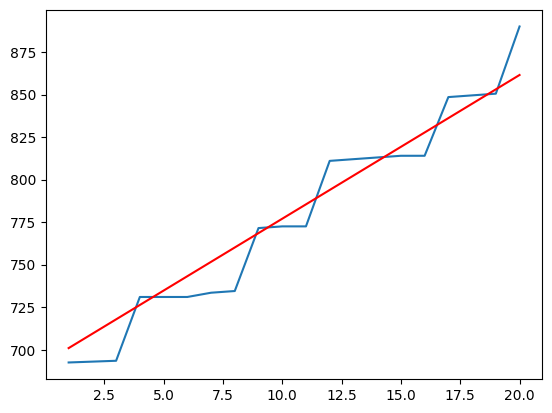

In [27]:
x = np.linspace(1,df_products.shape[0],num=df_products.shape[0])
#plt.plot(x,df_products.y_tl)
plt.plot(x[0:20],df_products.mean_y[0:20])
#plt.plot(x,df_products.y_tr)
#plt.plot(x,df_products.y_bl)
#plt.plot(x,df_products.y_br)
plt.plot(x[0:20],x[0:20]*slope+min(df_products.mean_y[0:20]),'r')

In [15]:
slope = (max(df_products.mean_y)-min(df_products.mean_y))/df_products.shape[0]

In [17]:
y_flat = df_products.mean_y - slope*x-min(df_products.mean_y)

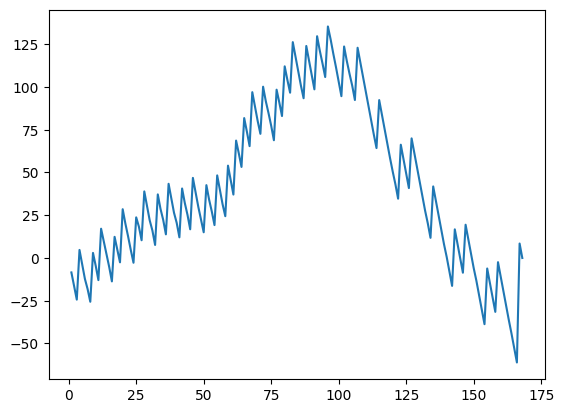

In [29]:
plt.plot(x,y_flat)